In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect ,func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement_ = Base.classes.measurement
Station_ = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Measurement_).first()
first_row.__dict__

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
first_row = session.query(Station_).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x290a64ea520>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Climate Analysis

Text(0, 0.5, 'inches')

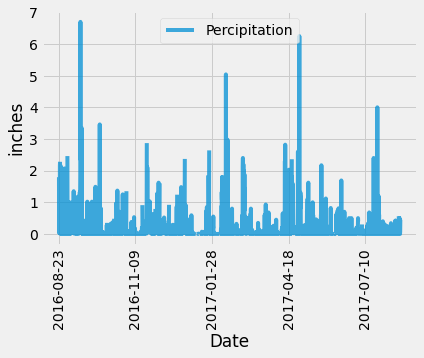

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last value in the query
measurement_last_date = session.query(Measurement_).order_by(Measurement_.date.desc()).first()
measurement_last_date = datetime.strptime(measurement_last_date.date, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
query_date = measurement_last_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
# Last 12 months data
lst_12month = session.query(Measurement_.date, Measurement_.prcp).\
    filter(Measurement_.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lst_12month, columns=['Date',"Percipitation"])
# Sort the dataframe by date

#df['Date'] = df['Date'].fillna(0)

df = df.set_index('Date')
df = df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(alpha=0.75, rot=90)
plt.ylabel("inches")
#plt.tight_layout()
#plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
nostation = session.query(Station_).group_by('station').count()
nostation1 = session.query(Measurement_).group_by('station').count()

for row in session.query(Station_.station).group_by('station'):
    print(row)

('USC00511918',)
('USC00513117',)
('USC00514830',)
('USC00516128',)
('USC00517948',)
('USC00518838',)
('USC00519281',)
('USC00519397',)
('USC00519523',)


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
a = session.query(Measurement_.station, func.count(Measurement_.station)).group_by('station').order_by(func.count(Measurement_.station).desc()).all()
most_active_stn = a[0][0]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Lowest temperature recorded for msot active station
lowest_temp = session.query(func.min(Measurement_.tobs)).\
    filter(Measurement_.station == most_active_stn).scalar()

# Highest temperature recorded for msot active station
highest_temp = session.query(func.max(Measurement_.tobs)).\
    filter(Measurement_.station == most_active_stn).scalar()

# Average temperature recorded for msot active station
average_temp = session.query(func.avg(Measurement_.tobs)).\
    filter(Measurement_.station == most_active_stn).scalar()


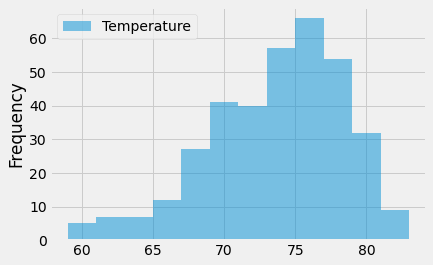

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

measurement_last_date = session.query(Measurement_).order_by(Measurement_.date.desc()).\
    filter(Measurement_.station == most_active_stn).first()
measurement_last_date = datetime.strptime(measurement_last_date.date, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
query_date = measurement_last_date - dt.timedelta(days=366)

lst_12month = session.query(Measurement_.date, Measurement_.tobs).\
    filter(Measurement_.date >= query_date).\
    filter(Measurement_.station == most_active_stn).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lst_12month, columns=['Date',"Temperature"])

#df.groupby(['Temperature']).count()
ax = df.plot.hist(bins=12, alpha =0.5)


## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement_.tobs), func.avg(Measurement_.tobs), func.max(Measurement_.tobs)).\
        filter(Measurement_.date >= start_date).filter(Measurement_.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2011-02-28', '2011-03-05')


[(61.0, 69.75510204081633, 75.0)]

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement_.tobs), func.avg(Measurement_.tobs), func.max(Measurement_.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement_.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
